# Initializing Environment

In [1]:
!pip install arabert
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186468 sha256=ed7ed4dbfb96cf0d98addce8ec2ba5100f24ee0c3a87c255d887e12c21a1c2a6
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.5.0
    Uninstalling emoji-2.5.0:
      Successfully uninstalled emoji-2.5.0


In [2]:
import pandas as pd
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer,AutoModel
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout,Conv1D,MaxPooling1D,Reshape
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Data

In [3]:
labeledData=pd.read_csv('/kaggle/input/labeledarticles/labeled_data.csv')

In [4]:
labeledData = labeledData.sample(frac=1, random_state=np.random.RandomState(seed=56))

In [5]:

labeledData['label']=labeledData['label'].replace(['not credible','credible'],[0,1])
real = labeledData[labeledData['label']==1]
fake = labeledData[labeledData['label']==0]
real = real.sample(n=len(fake), random_state=101)
labeledData = pd.concat([real,fake],axis=0)


In [7]:
labeledData = labeledData.sample(frac=1, random_state=np.random.RandomState(seed=42))
labeledData = labeledData.reset_index(drop=True)

In [8]:
print(labeledData.shape)
labeledData.head()

(334466, 5)


,title,text,publishing_date,source_num,label
0,كورونا في تونس: 61 حالة وفاة و1422 اصابة جديدة,قالت وزارة الصحة في بلاغ لها قبل قليل انه في إ...,2021-05-29T21:19:03+02:00,source_75,1
1,التشكيلتان الأساسيتان لمباراة الترجي والنجم ال...,ستنطلق بعد قليل (بدايةً من الساعة الثالثة بعد ...,2021-05-26T14:11:00,source_134,1
2,تأجيل إطلاق القمر السعودي شاهين سات,أعلنت مدينة الملك عبدالعزيز للعلوم والتقنية، أ...,2021-03-20T06:20:03+00:00,source_65,0
3,حجر صحي شامل: اللجنة العلمية تحسم الأمر,أكد عضو اللجنة العلمية لمجابهة انتشار فيروس كو...,2021-06-24T13:37:12+01:00,source_59,0
4,من هو الابن البكر للملك فيصل,من هو الابن الأكبر للملك فيصل بن عبد العزيز آل...,2021-05-12T02:22:03+00:00,source_65,0


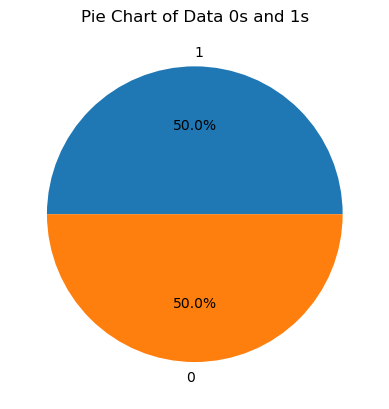

In [9]:
data_value_counts=labeledData['label'].value_counts()
plt.pie(data_value_counts,labels=data_value_counts.index,autopct='%1.1f%%')
plt.title('Pie Chart of Data 0s and 1s')
plt.show()

In [12]:
# #preprocessed=[arabert_prep.preprocess(txtt) for txtt in train_text]
# train_text,temp_text,train_labels,temp_labels=train_test_split(labeledData['title'],labeledData['label'],random_state=50,test_size=0.2)
# val_text,test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,random_state=50,test_size=0.5)

In [10]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)
preprocessed=[arabert_prep.preprocess(txtt) for txtt in labeledData['title']]
train_text,temp_text,train_labels,temp_labels=train_test_split(preprocessed,labeledData['label'],random_state=50,test_size=0.2)
val_text,test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,random_state=50,test_size=0.1)

/opt/conda/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:21<00:00, 11.4MiB/s] 


[2023-07-02 20:28:47,300 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# Bert

In [11]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_tokenizer=AutoTokenizer.from_pretrained(model_name)
arabert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number Of Texts')

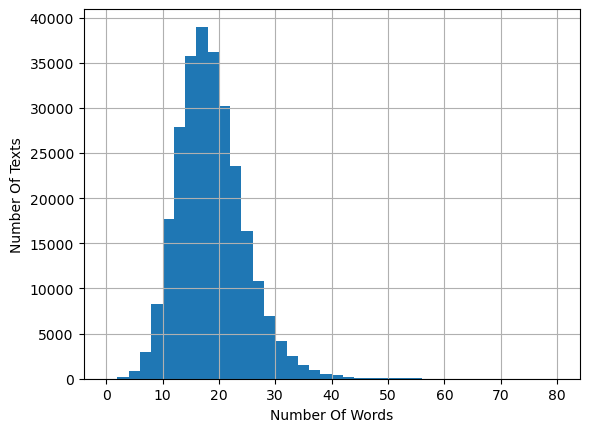

In [12]:
lengths=[len(title.split()) for title in train_text]
pd.Series(lengths).hist(bins=40)
plt.xlabel('Number Of Words')
plt.ylabel('Number Of Texts')

In [13]:
sample_texts = ["مرحبا بالعالم","أنا أحب تعلم اللغات الجديدة"]
#preprocessed=txt=[arabert_prep.preprocess(txtt) for txtt in sample_texts]
tokenized_sample=arabert_tokenizer.batch_encode_plus(sample_texts,padding=True)
tokenized_sample

{'input_ids': [[33, 9950, 195, 4350, 4372, 199, 34, 31, 31], [33, 1412, 4454, 3305, 2929, 55278, 27099, 51659, 34]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [14]:
max_len=24
tokens_train=arabert_tokenizer.batch_encode_plus(
    train_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )
tokens_val=arabert_tokenizer.batch_encode_plus(
    val_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )
tokens_test=arabert_tokenizer.batch_encode_plus(
    test_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )

In [16]:
train_input_ids=torch.tensor(tokens_train['input_ids'])
train_attention_masks=torch.tensor(tokens_train['attention_mask'])
train_y=torch.tensor(train_labels.tolist())

test_input_ids=torch.tensor(tokens_test['input_ids'])
test_attention_masks=torch.tensor(tokens_test['attention_mask'])
test_y=torch.tensor(test_labels.tolist())

val_input_ids=torch.tensor(tokens_val['input_ids'])
val_attention_masks=torch.tensor(tokens_val['attention_mask'])
val_y=torch.tensor(val_labels.tolist())

In [17]:
type(train_input_ids)

torch.Tensor

In [19]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_input_ids, train_attention_masks, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_input_ids, val_attention_masks, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

# Freeze Bert Layers

In [20]:
for param in arabert_model.parameters():
    param.requires_grad = False  

# Architecture

In [84]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(arabert_model)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

In [22]:
class BERT_Arch_LSTM(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch_LSTM, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)  # Update the input size of fc2
        self.softmax = nn.LogSoftmax(dim=1)
        self.lstm = nn.LSTM(512, 256, bidirectional=True)  # Add LSTM layer

    def forward(self, sentid, mask):
        token_output = self.bert(sentid, attention_mask=mask)
        last_hidden_state = token_output.last_hidden_state
        x = self.fc1(last_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(1, 0, 2)  # Reshape for LSTM: (seq_len, batch_size, input_size)
        lstm_output, _ = self.lstm(x)
        lstm_output = lstm_output.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, hidden_size)
        lstm_output = lstm_output[:, -1, :]  # Take the last output of the sequence (corresponds to the [CLS] token)
        x = self.fc2(lstm_output)
        x = self.softmax(x)
        return x

model = BERT_Arch_LSTM(arabert_model)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

# Model Functions

In [23]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 200 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 200 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

# Load Previous model if needed

In [24]:
model.load_state_dict(torch.load('/kaggle/input/weights-3/c7_new_model_weights.pt'))

<All keys matched successfully>

# Train Model

In [25]:
best_valid_loss = evaluate()
print(best_valid_loss)
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]


Evaluating...
  Batch   200  of  1,882.
  Batch   400  of  1,882.
  Batch   600  of  1,882.
  Batch   800  of  1,882.
  Batch 1,000  of  1,882.
  Batch 1,200  of  1,882.
  Batch 1,400  of  1,882.
  Batch 1,600  of  1,882.
  Batch 1,800  of  1,882.
0.5517175409479679


In [27]:
# Train and predict


for epoch in range(1):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c6_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch   200  of  8,362.
  Batch   400  of  8,362.
  Batch   600  of  8,362.
  Batch   800  of  8,362.
  Batch 1,000  of  8,362.
  Batch 1,200  of  8,362.
  Batch 1,400  of  8,362.
  Batch 1,600  of  8,362.
  Batch 1,800  of  8,362.
  Batch 2,000  of  8,362.
  Batch 2,200  of  8,362.
  Batch 2,400  of  8,362.
  Batch 2,600  of  8,362.
  Batch 2,800  of  8,362.
  Batch 3,000  of  8,362.
  Batch 3,200  of  8,362.
  Batch 3,400  of  8,362.
  Batch 3,600  of  8,362.
  Batch 3,800  of  8,362.
  Batch 4,000  of  8,362.
  Batch 4,200  of  8,362.
  Batch 4,400  of  8,362.
  Batch 4,600  of  8,362.
  Batch 4,800  of  8,362.
  Batch 5,000  of  8,362.
  Batch 5,200  of  8,362.
  Batch 5,400  of  8,362.
  Batch 5,600  of  8,362.
  Batch 5,800  of  8,362.
  Batch 6,000  of  8,362.
  Batch 6,200  of  8,362.
  Batch 6,400  of  8,362.
  Batch 6,600  of  8,362.
  Batch 6,800  of  8,362.
  Batch 7,000  of  8,362.
  Batch 7,200  of  8,362.
  Batch 7,400  of  8,362.
  Batch 7,600  of  8,362

In [ ]:
# Train and predict


for epoch in range(1):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c7_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [ ]:
print(evaluate())

# Test

In [ ]:
model.load_state_dict(torch.load('c2_new_model_weights.pt'))

In [113]:
torch.save(model.state_dict(), 'c1_new_model_weights.pt')


In [28]:
from sklearn.metrics import classification_report
# test_input_ids=torch.tensor(tokens_test['input_ids'])
# test_attention_masks=torch.tensor(tokens_test['attention_mask'])
# test_y=torch.tensor(test_labels.tolist())
with torch.no_grad():
  preds = model(test_input_ids, test_attention_masks)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71      3369
           1       0.71      0.66      0.68      3321

    accuracy                           0.70      6690
   macro avg       0.70      0.70      0.70      6690
weighted avg       0.70      0.70      0.70      6690



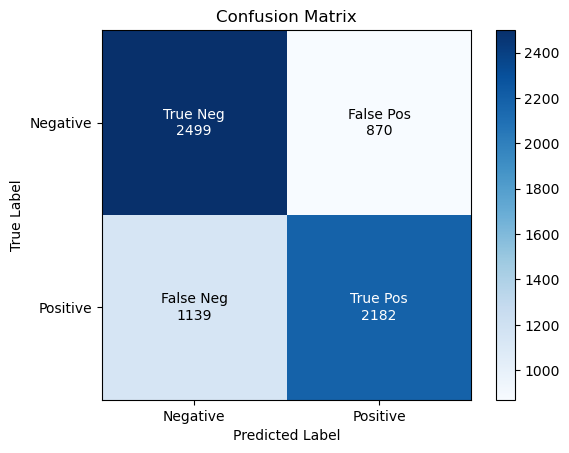

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, preds)


labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

# Calculate values for the diagonal cells
values = [f"{value:.0f}" for value in cm.flatten()]

# Combine labels and values
cell_text = [f"{label}\n{value}" for label, value in zip(labels, values)]

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=[0, 1], yticks=[0, 1], xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], title='Confusion Matrix', ylabel='True Label', xlabel='Predicted Label')
ax.set_ylim(1.5, -0.5) # Fix for matplotlib bug that cuts off top and bottom cells of matrix
for i in range(2):
    for j in range(2):
        ax.text(j, i, cell_text[i*2+j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.show()
# Plot confusion matrix
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# tick_marks = [0, 1]
# plt.xticks(tick_marks, ['Negative', 'Positive'])
# plt.yticks(tick_marks, ['Negative', 'Positive'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

<a href="/kaggle/working/c5_new_model_weights.pt"> Download File </a>
